In [ ]:
import json
json_key = {"username":"N/A","key":"N/A"}
with open("kaggle.json",'w') as file:
  json.dump(json_key,file)

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d adityajn105/flickr8k
!unzip -q flickr8k.zip
!rm flickr8k.zip

 99% 1.03G/1.04G [00:10<00:00, 119MB/s]
100% 1.04G/1.04G [00:10<00:00, 101MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import glob,cv2,time
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from transformers import BertTokenizer
from tokenizers import BertWordPieceTokenizer

! pip install transformers
! pip install tokenizers

In [ ]:
df = pd.read_csv('captions.txt')
df.head(20)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [ ]:
df_train = df.sample(frac=0.85,random_state=42)
df_test = df.drop(df_train.index)

## Tokenizers

In [ ]:
with open('captions.txt','r') as inp_file:
  for inp_line in inp_file.readlines()[1:]:
    with open('only_captions.txt','a') as out_file:
      out_file.write(",".join(inp_line.split(',')[1:]))

In [ ]:
files = glob.glob('only_captions.txt')

# Initialize an empty tokenizer
tokenizer = BertWordPieceTokenizer(
    clean_text=True,
    handle_chinese_chars=True,
    strip_accents=True,
    lowercase=True,
)

# And then train
tokenizer.train(
    files,
    vocab_size=5000,
    min_frequency=2,
    show_progress=True,
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"],
    limit_alphabet=1000,
    wordpieces_prefix="##",
)

# Save the files
tokenizer.save_model('./', 'bert-flickr')

['./bert-flickr-vocab.txt']

In [ ]:
NPY_DIR = 'drive/MyDrive/Flickr8k/inception_resnet_v2/'
MAX_DECODER_LEN = 100

flickr_tokenizer = BertWordPieceTokenizer('bert-flickr-vocab.txt')
flickr_tokenizer.enable_padding(direction='right', length=MAX_DECODER_LEN)

## Image Features caching

In [ ]:
cnn_feature_extractor = tf.keras.applications.InceptionResNetV2(include_top=False,input_shape=(299,299,3))
x = layers.Reshape(target_shape=(-1,cnn_feature_extractor.output.shape[-1]))(cnn_feature_extractor.output)
cnn_fts_extractor = tf.keras.Model(inputs=[cnn_feature_extractor.input],outputs=[x])

print(cnn_fts_extractor.output)

219070464/219055592 [==============================] - 1s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 1536), dtype=tf.float32, name=None), name='reshape/Reshape:0', description="created by layer 'reshape'")


In [ ]:
def load_image(image_path):
    img = tf.io.read_file('Images/' + image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299,299))
    img = tf.keras.applications.inception_resnet_v2.preprocess_input(img)
    return img, image_path

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


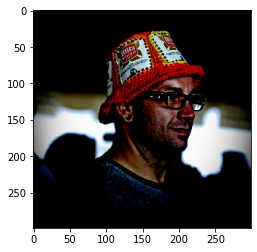

In [ ]:
plt.imshow(load_image(df['image'][22])[0])

In [ ]:
image_dataset = tf.data.Dataset.from_tensor_slices(df['image'].values)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(64)

for img, path in tqdm(image_dataset):
  batch_features = cnn_fts_extractor(img)

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(NPY_DIR + path_of_feature, bf.numpy())

100%|██████████| 1265/1265 [24:44<00:00,  1.17s/it]


## Config file

In [ ]:
class CONFIG:
  num_heads = 8
  num_layers = 6

  max_position_encoding = MAX_DECODER_LEN
  embedding_dim = 128
  fully_connected_dim = 512
  target_vocab_size = flickr_tokenizer.get_vocab_size()

  dropout_rate = 0.1
  layernorm_eps = 1e-6

  ## inception_resnet - 1536, inception - 2048
  img_fts_shape = cnn_fts_extractor.output.shape
  use_encoder = True


dict_config ={key:value for key, value in CONFIG.__dict__.items() if not key.startswith('__')}
print(dict_config)

{'num_heads': 8, 'num_layers': 6, 'max_position_encoding': 100, 'embedding_dim': 128, 'fully_connected_dim': 512, 'target_vocab_size': 5000, 'dropout_rate': 0.1, 'layernorm_eps': 1e-06, 'img_fts_shape': TensorShape([None, 64, 1536]), 'use_encoder': True}


## Transformer Architecture

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates


def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],np.arange(d_model)[np.newaxis, :],d_model)
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
  pos_encoding = angle_rads[np.newaxis, ...]
  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  # add extra dimensions to add the padding to the attention logits.
  # (batch_size, 1, 1, seq_len)
  return seq[:, tf.newaxis, tf.newaxis, :]  


def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [ ]:
def FeedForward(embedding_dim, fully_connected_dim):
  return tf.keras.Sequential([
      # (batch_size, seq_len, fully_connected_dim)
      tf.keras.layers.Dense(fully_connected_dim, activation='relu'),
      # (batch_size, seq_len, embedding_dim)
      tf.keras.layers.Dense(embedding_dim)
  ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):

    def __init__(self,config):
        super(EncoderLayer, self).__init__()

        self.mha = layers.MultiHeadAttention(num_heads=config['num_heads'],key_dim=config['embedding_dim'])
        self.ffn = FeedForward(embedding_dim=config['embedding_dim'],fully_connected_dim=config['fully_connected_dim'])

        self.layernorm1 = layers.LayerNormalization(epsilon=config['layernorm_eps'])
        self.layernorm2 = layers.LayerNormalization(epsilon=config['layernorm_eps'])

        self.dropout1 = layers.Dropout(config['dropout_rate'])
        self.dropout2 = layers.Dropout(config['dropout_rate'])
    

    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """

        # calculate self-attention using mha
        attn_output = self.mha(x, x, x, mask)  # Self attention (batch_size, input_seq_len, embedding_dim)
        
        # apply dropout layer to the self-attention output
        attn_output = self.dropout1(attn_output, training = training)
        
        # apply layer normalization on sum of the input and the attention output to get the  
        # output of the multi-head attention layer
        out1 = self.layernorm1(x + attn_output)

        # pass the output of the multi-head attention layer through a ffn 
        ffn_output = self.ffn(out1)
        
        # apply dropout layer to ffn output
        ffn_output = self.dropout2(ffn_output, training = training)
        
        # apply layer normalization on sum of the output from multi-head attention and ffn output to get the
        # output of the encoder layer
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, embedding_dim)
        
        return out2

In [ ]:
class Encoder(tf.keras.layers.Layer):

    def __init__(self,config):
        super(Encoder, self).__init__()

        self.embedding_dim = config['embedding_dim']
        self.num_layers = config['num_layers']

        self.dropout = layers.Dropout(config['dropout_rate'])
        #self.embedding = layers.Embedding(config['input_vocab_size'], self.embedding_dim)
        #self.pos_encoding = positional_encoding(maximum_position_encoding,self.embedding_dim)
        self.enc_layers = [EncoderLayer(config) for _ in range(self.num_layers)]


    def call(self, x, training, mask):
        """
        Forward pass for the Encoder
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        
        # Pass input through the Embedding layer
        # (batch_size, input_seq_len, embedding_dim)
        # x = self.embedding(x)  

        # Scale embedding by multiplying it by the square root of the embedding dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))

        # Add the position encoding to embedding
        #seq_len = tf.shape(x)[1]
        #x += self.pos_encoding[:, :seq_len, :]

        # Pass the encoded embedding through a dropout layer
        x = self.dropout(x, training = training)

        # Pass the output through the stack of encoding layers
        # (batch_size, input_seq_len, embedding_dim) 
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):

    def __init__(self,config):
        super(DecoderLayer, self).__init__()

        self.mha1 = layers.MultiHeadAttention(num_heads=config['num_heads'],key_dim=config['embedding_dim'])
        self.mha2 = layers.MultiHeadAttention(num_heads=config['num_heads'],key_dim=config['embedding_dim'])
        self.ffn = FeedForward(embedding_dim=config['embedding_dim'],fully_connected_dim=config['fully_connected_dim'])

        self.layernorm1 = layers.LayerNormalization(epsilon=config['layernorm_eps'])
        self.layernorm2 = layers.LayerNormalization(epsilon=config['layernorm_eps'])
        self.layernorm3 = layers.LayerNormalization(epsilon=config['layernorm_eps'])

        self.dropout1 = layers.Dropout(config['dropout_rate'])
        self.dropout2 = layers.Dropout(config['dropout_rate'])
        self.dropout3 = layers.Dropout(config['dropout_rate'])
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, fully_connected_dim)
            training -- Boolean, set to true to activate the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            out3 -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            attn_weights_block1 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
            attn_weights_block2 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
        """
                
        # BLOCK 1
        # calculate self-attention and return attention scores as attn_weights_block1
        # (batch_size, target_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask, return_attention_scores=True)  
        
        # apply dropout layer on the attention output
        attn1 = self.dropout1(attn1, training = training)
        
        # apply layer normalization to the sum of the attention output and the input
        out1 = self.layernorm1(attn1 + x)

        # BLOCK 2
        # calculate self-attention using the Q from the first block and K and V from the encoder output.
        # Return attention scores as attn_weights_block2 
        # (batch_size, target_seq_len, d_model)
        attn2, attn_weights_block2 = self.mha2(out1, enc_output, enc_output, padding_mask, return_attention_scores=True) 
        
        # apply dropout layer on the attention output
        attn2 = self.dropout2(attn2, training = training)
        
        # apply layer normalization to the sum of the attention output and the output of the first block
        # (batch_size, target_seq_len, fully_connected_dim) 
        out2 = self.layernorm2(attn2 + out1) 
        
        #BLOCK 3
        # pass the output of the second block through a ffn
        # (batch_size, target_seq_len, fully_connected_dim)
        ffn_output = self.ffn(out2) 
        
        # apply a dropout layer to the ffn output
        ffn_output = self.dropout3(ffn_output, training = training)
        
        # apply layer normalization to the sum of the ffn output and the output of the second block
        # (batch_size, target_seq_len, fully_connected_dim)
        out3 = self.layernorm3(ffn_output + out2) 

        return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Decoder(tf.keras.layers.Layer):

    def __init__(self, config):
        super(Decoder, self).__init__()

        self.embedding_dim = config['embedding_dim']
        self.num_layers = config['num_layers']

        self.embedding = layers.Embedding(config['target_vocab_size'], self.embedding_dim)
        self.pos_encoding = positional_encoding(config['max_position_encoding'], self.embedding_dim)

        self.dec_layers = [DecoderLayer(config) for _ in range(self.num_layers)]
        self.dropout = layers.Dropout(config['dropout_rate'])
    

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attention_weights - Dictionary of tensors containing all the attention weights
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        # create word embeddings 
        # (batch_size, target_seq_len, embedding_dim)
        x = self.embedding(x)  
        
        # scale embeddings by multiplying by the square root of their dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        
        # calculate positional encodings and add to word embedding
        x += self.pos_encoding[:, :seq_len, :]
        
        # apply a dropout layer to x
        x = self.dropout(x, training = training)

        # use a for loop to pass x through a stack of decoder layers and update attention_weights
        for i in range(self.num_layers):
            # pass x and the encoder output through a stack of decoder layers and save the attention weights
            # of block 1 and 2 
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            #update attention_weights dictionary with the attention weights of block 1 and block 2
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = block2
        
        # x.shape == (batch_size, target_seq_len, embedding_dim)
        return x, attention_weights

In [ ]:
class Transformer(tf.keras.Model):

  def __init__(self, config):
    super().__init__()
    self.encoder = Encoder(config)
    self.decoder = Decoder(config)
    self.densor = layers.Dense(config['embedding_dim'])
    self.final_layer = layers.Dense(config['target_vocab_size'], activation='softmax')


  def call(self, inputs, use_encoder, training):

    inp, tar = inputs
    look_ahead_mask = self.create_masks(inp, tar)
    # applies dense layer to img fetures
    inp = self.densor(inp)

    # (batch_size, inp_seq_len, embedding_dim)
    if use_encoder:
      enc_output = self.encoder(inp, training, None)
    else:
      enc_output = inp

    # dec_output.shape == (batch_size, tar_seq_len, embedding_dim)
    dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, None)
    # (batch_size, tar_seq_len, target_vocab_size)
    final_output = self.final_layer(dec_output) 

    return final_output, attention_weights


  def create_masks(self, inp, tar):

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return look_ahead_mask

## Data Loaders

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1024

In [ ]:
def preprocess(img_name, caption):
  cap = tf.constant(flickr_tokenizer.encode(caption.decode('utf-8')).ids)
  cap = tf.reshape(cap,(-1,))
  img_tensor = tf.constant(np.load(NPY_DIR + img_name.decode('utf-8') +'.npy'))
  return img_tensor,cap

In [ ]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .map(lambda item1, item2: tf.numpy_function(
           preprocess, (item1, item2), (tf.float32, tf.int32)),
           num_parallel_calls=tf.data.AUTOTUNE)
      .batch(BATCH_SIZE)
      .prefetch(tf.data.AUTOTUNE))

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((df_train.values[:,0],df_train.values[:,1]))
train_ds = make_batches(train_dataset)

test_dataset = tf.data.Dataset.from_tensor_slices((df_test.values[:,0],df_test.values[:,1]))
test_ds = make_batches(test_dataset)

In [ ]:
list(train_ds.take(1))

[(<tf.Tensor: shape=(64, 64, 1536), dtype=float32, numpy=
  array([[[6.0358274e-01, 2.4442109e-01, 0.0000000e+00, ...,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [2.8696880e-01, 1.3751945e-01, 0.0000000e+00, ...,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 6.8616605e-01, 0.0000000e+00],
          ...,
          [5.2523029e-01, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 6.9872254e-01, 1.7795796e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           1.3203050e-01, 2.3288310e+00, 0.0000000e+00],
          [1.5698242e-01, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 4.4253201e+00, 0.0000000e+00]],
  
         [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
           0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 3.7947305e-02, 1.8931247e-03, ...,
           2.0318979e-03, 0.0000000e

## Training

In [ ]:
EPOCHS = 20
LR = 0.006

In [ ]:
model = Transformer(dict_config)
optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):

  accuracies = tf.equal(real, tf.cast(tf.argmax(pred, axis=2),dtype=tf.int32))
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)
  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.Mean(name='test_accuracy')

In [ ]:
checkpoint_path = "/drive/MyDrive/Flickr8k/ckpts/encoder_true"
ckpt = tf.train.Checkpoint(transformer=model,optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
step_signature = [
    tf.TensorSpec(shape=dict_config['img_fts_shape'], dtype=tf.float32),
    tf.TensorSpec(shape=(None,dict_config['max_position_encoding']), dtype=tf.int32),
    tf.TensorSpec(shape=(), dtype=tf.bool)]


@tf.function(input_signature = step_signature)
def train_step(input_emb,target_seq,use_encoder):
  tar_inp = target_seq[:, :-1]
  tar_real = target_seq[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = model([input_emb, tar_inp],use_encoder=use_encoder,training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))


@tf.function(input_signature = step_signature)
def test_step(input_emb,target_seq,use_encoder):
  tar_inp = target_seq[:, :-1]
  tar_real = target_seq[:, 1:]

  predictions, _ = model([input_emb, tar_inp],use_encoder=use_encoder,training = False)
  loss = loss_function(tar_real, predictions)

  test_loss(loss)
  test_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
for epoch in range(EPOCHS):

  start = time.time()
  enum_train_ds = tqdm(enumerate(train_ds))
  enum_test_ds = tqdm(enumerate(test_ds))

  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for (batch, (img_emb, target_seq)) in enum_train_ds:
    train_step(img_emb,target_seq,tf.constant(dict_config['use_encoder']))
    enum_train_ds.set_description(f'Epoch - {epoch + 1}/{EPOCHS}; Batch - {batch}/{len(train_ds)} ||' 
    + f' Loss - {train_loss.result():.4f}; Accuracy - {train_accuracy.result():.4f}')
  
  for (batch, (img_emb, target_seq)) in enum_test_ds:
    test_step(img_emb,target_seq,tf.constant(dict_config['use_encoder']))
    enum_test_ds.set_description(f'Epoch - {epoch + 1}/{EPOCHS}; Batch - {batch}/{len(test_ds)} ||' 
    + f' Loss - {test_loss.result():.4f}; Accuracy - {test_accuracy.result():.4f}')
  
  if (epoch + 1) % 2 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs')
  print('-'* 200)

0it [00:00, ?it/s]
Epoch - 1/20; Batch - 188/538 || Loss - 5.4804; Accuracy - 0.1177: : 189it [30:04,  4.91s/it]